# Caliban Fig8 Upload Pipeline
This pipeline creates a Figure Eight job and uploads data files to an S3 bucket for data curation.

- Create npz
- Resize npz into smaller pieces (image dimensions) if needed
- Upload files to AWS
- Create job csv and upload it to figure 8

**Note: if you need to start a Caliban job to correct the results of a previous Caliban job, please set "base_dir" then skip to the end of the notebook.**

In [1]:
# import statements
from __future__ import absolute_import

import math
import numpy as np
import os
import matplotlib.pyplot as plt
import xarray as xr

from deepcell_toolbox.pre_annotation.npz_preprocessing import reshape_npz, slice_npz_batches, slice_npz_folder, relabel_npzs_folder, crop_multichannel_data
from deepcell_toolbox.post_annotation.npz_postprocessing import reconstruct_image_stack
from deepcell_toolbox.pre_annotation.aws_upload import aws_caliban_upload
from deepcell_toolbox.pre_annotation.caliban_csv import initial_csv_maker, create_next_CSV
from deepcell_toolbox.pre_annotation.fig_eight_upload import fig_eight

## Create npz (if needed)

We'll skip this for now since we already have a lot of npzs created. Also, the fig8 image download pipeline includes create_training_data. This part would mostly be for creating npz files from model outputs.

In [ ]:
# read in folders of annotated 2D images with corresponding labels, convert to NPZ files
# function TBD depending on final format of NPZ data

## Split npz into pieces (semi-optional)
The idea is that you'd be starting from one huge npz and breaking it into managable pieces. This part will probably include:
- break up each npz into fewer frames (annotator does not necessarily need to do all 30+ frames of a movie at once)
- save these reshaped pieces as individual npz files, so they can be uploaded and worked on separately
- relabel the npzs as needed (choose between no relabel, relabel each cell in each frame to have unique label, or relabel to have unique labels but preserve 3D relationships)

These pieces will need specific names so that we can put them back together again if needed (especially putting frames back into longer contiguous movies).

In [2]:
base_dir = '../example_data/'
save_dir = os.path.join(base_dir, "example_crop_dir")
example_stack = "example_xr.xr"
full_path = os.path.join(base_dir, example_stack)

### Crop npz into smaller x and y pieces
Takes an npz file and splits it into many smaller overlapping npzs, each of which can be submitted a separate Figure8 job

In [3]:
crop_multichannel_data(xarray_path=full_path, folder_save=save_dir, crop_size=(200, 200), overlap_frac=0.2, 
                       blank_labels="skip", save_format="xr", relabel=True)

Point8_row_6_col_0 is blank, skipping saving
Point8_row_6_col_6 is blank, skipping saving


### Check crop size
Visualizes and overlay of the crops over the original imaging data, as well as an individual crop

In [13]:
# load info from crop
import json

with open(os.path.join(base_dir, save_dir, "log_data.json")) as json_file:
    log_data = json.load(json_file)

fov_names, row_start, col_start = log_data["fov_names"], log_data["row_start"], log_data["col_start"]

example_xr = xr.open_dataarray(os.path.join(save_dir, fov_names[0] + "_row_0_col_0.xr"))
original_xr = xr.open_dataarray(full_path)

original_xr[0, row_start, :, 2] = np.max(original_xr)
original_xr[0, :, col_start, 2] = np.max(original_xr)

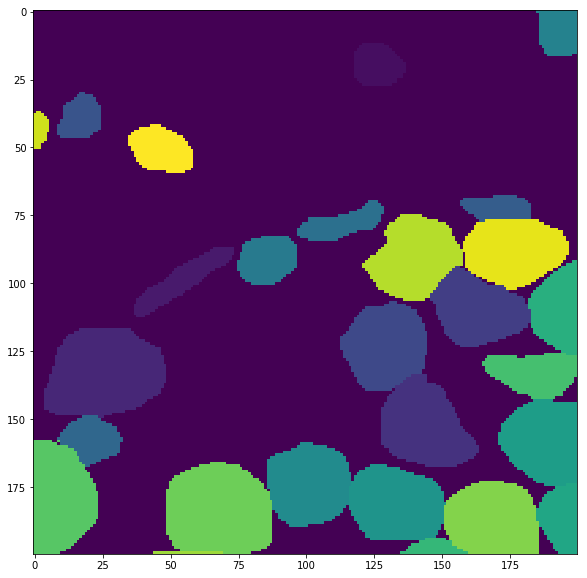

In [8]:
plt.figure(figsize = (10, 10))
plt.imshow(example_xr[:, :, 2])

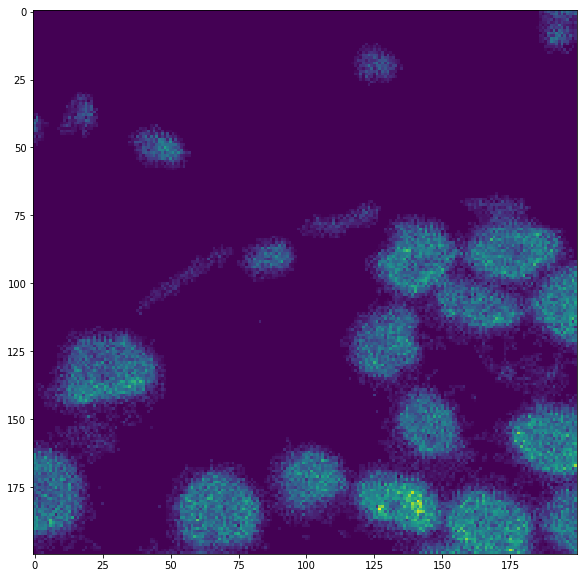

In [10]:
plt.figure(figsize = (10, 10))
plt.imshow(example_xr[:, :, 0])

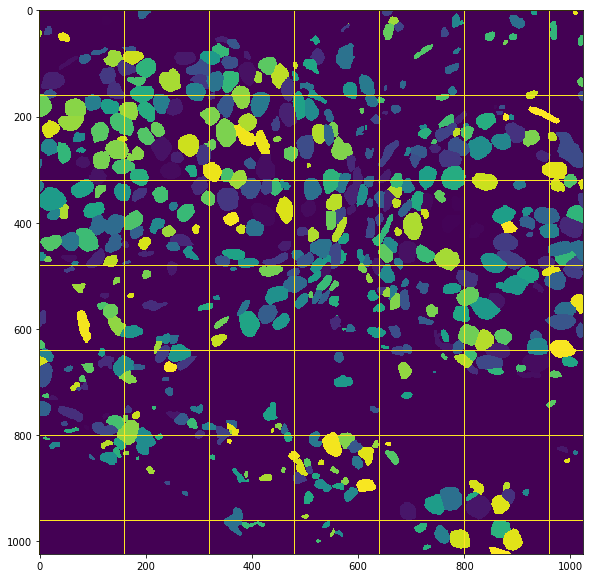

In [14]:
plt.figure(figsize = (10, 10))
plt.imshow(original_xr[0, :, :, 2])

## Upload pieces to AWS

### Select directory

"base_dir" is a directory that holds the desired .npz or .trk file folder for data curation. This will go through the folder and upload the files to the desired S3 input bucket. 

In [ ]:
upload_dir = sliced_save_dir

In [ ]:
# bucket to load uncurated files
input_bucket = "caliban-input"

# bucket for curated files after submission
output_bucket = "caliban-output"

# subfolders in input/output bucket
aws_folder = "HeLa-S3/cyto/Stanford_movies/set7"

# stage becomes another subfolder so that data from subsequent jobs are grouped nearby
stage = 'firstpass'

filenames, filepaths = aws_caliban_upload(input_bucket, 
                                          output_bucket, 
                                          aws_folder, 
                                          stage, 
                                          folder_to_upload = upload_dir)

## Create CSV file for Figure Eight


Figure Eight jobs can be created easily by using a CSV file where each row contains information about one task. To create jobs for caliban, each row has a unique url that directs users to the Caliban tool with the correct data to curate. The CSV file is saved as {identifier}\_{stage}\_upload.csv in a folder that only holds CSVs.

In [ ]:
csv_dir = os.path.join(base_dir, "CSV")
identifier = "HeLa-S3_cyto_movies_s7"

initial_csv_maker(csv_dir = csv_dir, 
                  identifier = identifier,
                  stage = stage,
                  input_bucket = input_bucket,
                  output_bucket = output_bucket,
                  subfolders = aws_folder,
                  filenames = filenames,
                  filepaths = filepaths)

## Create Figure Eight job

The Figure Eight API allows us to create a new job and upload data to it from this notebook. However, since our jobs don't include required test questions, editing job information such as the title of the job must be done via the website. This section of the notebook uses the API to create a job and upload data to it, then reminds the user to finish editing the job on the website.


In [ ]:
job_id_to_copy =  1463619 #Caliban first-pass job
# job_id_to_copy = _ #Caliban foreground/background correction job
# job_id_to_copy = _ #Caliban inter-cell fixes job
# job_id_to_copy = _ #Caliban tracking/lineage correction job
fig_eight(csv_dir, "{0}_{1}".format(identifier, stage), job_id_to_copy)

## Start Figure Eight job on results of previous job
Due to the complexity of Caliban jobs, full annotation correction takes place over several jobs, which each focus on correcting a different aspect of the file. To begin the next job in a sequence, the files must be moved from one bucket location (their output location) to the input location for the next job. A new CSV file must also be created for the next job.

In this step, the job report from the finished job is downloaded to the CSV folder. The user must input the "next_stage" that the next Figure 8 job will be focusing on; this information will supplement the information in the job report so that the appropriate files can be moved and the CSV file created. After this step has finished, use the "Create Figure Eight job" section to create a new job from the new CSV.

In [ ]:
csv_dir = os.path.join(base_dir, "CSV")
results_job_id = 1468933 #job ID for the results we need
next_stage = 'fgbg'
job_id_to_copy = 1472963 # instructions to copy for the 'next_stage' job we're creating now

In [ ]:
# identifier = create_next_CSV(csv_dir, results_job_id, next_stage)
identifier = 'HeLa-S3_cyto_movies_s7'
fig_eight(csv_dir, "{0}_{1}".format(identifier, next_stage), job_id_to_copy)

## Stitch npz files together
After annotation, stitches the npz files back together to original image size

In [ ]:
reconstruct_npz(npz_dir, original_npz_file)